# AAAI EM Iteration Notebook

Slightly modified for current system.


---

### Required:
- Tensors:
    - `X_test`: Testing Image Tensor
    - `Y_test`: Testing Label Tensor
    - `X_train`: Training Image Tensor
    - `X_val`: Validation Image Tensor
    - `train_offsets`: Window offsets for scanning `Y_train` as path to csv.
    - `val_offsets`: Window offsets for scanning `Y_val` as path to csv.

- `segments`: Candidate line segments accross training raster in directory

- `preweights`: pre-trained Weights for U-Net model on the passed `X_train`, `X_val` tensors

- `initial_pmap`: pmap output from baseline data

In [1]:
# -- All Imports --
import os, sys, time, csv

import tensorflow as tf
import numpy as np
import random as rand
import geopandas as gpd
import matplotlib.pyplot as plt

from lib.ModuleTools import *
from lib.UnetTools import *
import lib.GeoTools as gt
import lib.ShapeTools as st
import lib.EMTools as emt
import lib.LineGen as lg

# Parameters, Files
from lib.EMconfig import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# -- Module Information --
module_data = {
    'name': 'EM_Iteration', # Module Name
    'desc': 'Iterate over EM process', # Module Description
    'test_name': 'aaai_emtest', # Default test name
    'csv': 'master.csv', # Csv path
    'verbose': True # Default verbosity
}
test = ModuleTest(module_data)
# -------------------------


# -- Iteration Parameters --
iteration = {}

# Number of EM iterations
EM_target = wrap(2, iteration) 
 
# Constant Value for Learning Rate Schedule 
lr_const = wrap(2, iteration)

# optionally reset layer weights between iterations
rebuild_model = wrap( True, iteration)

# (epsilon) Chance that a candidate will be selected outside of the top candidate, within the K top candidates.
random_candidate_chance = wrap( 0, iteration)

# (K) Consider K top-weighted segments. set 1 for top candidate, set 0 to consider all.
weight_limit = wrap( 13, iteration)


# Option to load candidates, generally set to true
load_candidates = True

# The parameters below are defined in the /lib/EMconfig.py file. 
test.Pgroup("Iteration", iteration)
test.Pgroup("Environment", env)
test.Pgroup("Tensor Data", TensorConfig)
test.Pgroup("Annotation Configuration", Annotations)
test.Pgroup("UNet Config", unetcfg)
test.Pgroup('Baseline Directories', inputDirs)
test.Fgroup('Input Arrays', InputArrays)
test.Fgroup('Source_Data', sourceData)


""" Test Parameters """

# UNET configuration
learningRate = 0.05
learningRateReduced = 0.05

# Candidate Segment Directory - Generate with other notebook
#CandidateDirectory = '/data/GeometricErrors/aaai_data/segments'
CandidateDirectory = '/data/GeometricErrors/tests/aaai_system/Candidates/segment_sets_03/segments_03'
#04_new exp increase interval 15 1.5, 1.2 candidates
#03_No exp, equal interval, 20, 1.5 candidates
#02_No exp, equal interval, 15, 1.5

# Total number of EM steps
EM_target = 8

# Use random choice when selecting candidates below weight threshold (Implemented here)
default_random = False


mirror_strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

# ---------------
print(dt.now().strftime('Hyperparameters saved on %a at %I:%M:%S %p.'))

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Describe aaai_emtest_34:34
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Hyperparameters saved on Fri at 09:17:15 PM.


In [2]:
print(inputDirs)
inputDirs.update({"CandidateDirectory": CandidateDirectory})
unetcfg.update({"learningRate": learningRate})


{'CandidateDirectory': '/data/GeometricErrors/aaai_data/segments', 'preTrainedPath': '/data/GeometricErrors/aaai_data/preweights.h5', 'train_offsets_fp': '/data/GeometricErrors/aaai_data/train_offsets.csv', 'val_offsets_fp': '/data/GeometricErrors/aaai_data/val_offsets.csv'}


## Load Baseline Data

In [3]:
section_tstamp = time.time()
section_name = 'Prepare Base Data'
# --------------------

# 1. Shapefile Precisions
imp_labels = st.Flatten_Frame(imp_labels)
sourcePrecision = emt.GDF_Precision(gt_labels, imp_labels, precisionBuffer)
prevPrecision = sourcePrecision


# 2. Check Array Shapes
print("-- Inputs  --")
for (title, arr) in [('X_train',X_train), ('X_val',X_val), ('X_test',X_test), ('Y_test',Y_test)]:
    print("{} Shape: {}".format(title, arr.shape))

if load_candidates:
    # 3. Load Candidates 
    candidateFrames = lg.LoadCandidates(CandidateDirectory)
    print("\n-- Candidates  --")
    print("Loaded Candidate Frames: {}".format(len(candidateFrames)))
    print("Candidates Per Segment (~): {}".format(len(candidateFrames[0].geometry)))

    # 4. Add Windows and Masks to candidates
    tstamp = time.time()
    candidateFrames = [emt.CandidateWindows(initial_pmap, c_frame, weightBuffer) for c_frame in candidateFrames]
    %store candidateFrames
else:
    %store -r candidateFrames
    print("Recalled {} candidate frames.".format(len(candidateFrames)))


# --------------------
section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
test.Section(section_name, section_data)
# --------------------
if test.verbose:
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

-- Inputs  --
X_train Shape: (2792, 224, 224, 7)
X_val Shape: (160, 224, 224, 7)
X_test Shape: (200, 224, 224, 7)
Y_test Shape: (200, 224, 224, 1)

-- Candidates  --
Loaded Candidate Frames: 4711
Candidates Per Segment (~): 41
Stored 'candidateFrames' (list)

Prepare Base Data (01) Complete.
Fri at 09:46:08PM


In [4]:
section_tstamp = time.time()
section_name = 'Prepare Model'
# --------------------


# 5. Load Unet Model
from tensorflow.keras.optimizers import Adam
with mirror_strategy.scope():
    unet_model = UNET_7_224()
    unet_model.compile(optimizer=Adam(lr=learningRate), loss=dice_coef_loss, metrics=metrics)
    unet_model.load_weights(preTrainedPath)

print("\nInitialized U_Net model.")
print(dt.now().strftime('%a at %I:%M:%S%p'))

# 6. Evaluate Unet Model
# Save Training Results
train_results = emt.Evaluate(X_train, Y_train, unet_model)
# Save Validation Results
val_results = emt.Evaluate(X_val, Y_val, unet_model)
# Save Testing Results
test_results = emt.Evaluate(X_test, Y_test, unet_model)

y_pred=np.copy(unet_model.predict(X_test))
y_pred = np.round(y_pred)
y_true=np.copy(Y_test)
y_pred.shape = y_pred.shape[0]* y_pred.shape[1]*y_pred.shape[2]* y_pred.shape[3]
y_true.shape = y_true.shape[0]* y_true.shape[1]*y_true.shape[2]* y_true.shape[3]

c_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion Matrix", c_matrix)
report_unet = classification_report(y_true, y_pred)
print("report_unet", report_unet)

# Print the baseline metrics
print("\nRan Initial U_Net evaluation:")
print("\nBaseline Training Results:")
print("- {}".format(train_results[0]))
print("- {}".format(train_results[1]))
print("\nBaseline Validation Results:")
print("- {}".format(val_results[0]))
print("- {}".format(val_results[1]))
print("\nBaseline Testing Results:")
print("- {}".format(test_results[0]))
print("- {}".format(test_results[1]))
print("\nBaseline Shape Metrics")
print("- Precision: {:.2f}".format(sourcePrecision*100))
print(dt.now().strftime('%a at %I:%M:%S%p'))


# Save initial EM Data 
test.Results("Baseline Data", {
    'Precision': '{:.2f}%'.format(sourcePrecision*100),
    'UNet: Training Results': train_results,
    'UNet: Validation Results': val_results,
    'UNet: Testing Results': test_results,
    'UNet: Report': report_unet, 
    'UNet: Confusion Matrix': c_matrix
})


# Create Matrix to save step data in seperate CSV
dataMatrix = {
    'precision': [sourcePrecision*100],
    
    'trainDice': [train_results[0]],
    'trainF1Score': [train_results[1]],
    
    'valDice': [val_results[0]],
    'valF1Score': [val_results[1]],
    
    'testDice': [test_results[0]],
    'testF1Score': [test_results[1]]
}

# --------------------
section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
test.Section(section_name, section_data)
# --------------------
if test.verbose:
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## EM Iteration

Target Steps: 8
True


EM Step 00 begun.
Tue at 11:23:11PM

Generated Probability Output Map from previous model. (Step 00)
Tue at 11:23:37PM

Created New Annotation. (Step 00)
Tue at 11:24:59PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Tue at 11:25:12PM

New Learning Rate: 0.050000. (Step 00)
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
88/88 [==============================] - 15s 168ms/step - f1_score: 0.1319 - dice_coef: 0.1309 - loss: -0.1313 - accuracy: 0.8807 - val_f1_score: 0.0326 - val_dice_coef: 0.0326 - val_loss: -0.0326 - val_accuracy: 0.0168 - lr: 0.0500
Epoch 2/50
88/88 [==============================] - 12s 138ms/step - f1_score: 0.1580 - dice_coef: 0.1580 - loss: -0.1586 - accuracy: 0.9073 - val_f1_score: 0.0503 - val_dice_coef: 0.0503 - val_loss: -0.0503 - val_accuracy: 0.8519 - lr: 0.0500
Epoch 3/50

Epoch 30/50
88/88 [==============================] - 11s 126ms/step - f1_score: 0.2207 - dice_coef: 0.2207 - loss: -0.2223 - accuracy: 0.9155 - val_f1_score: 0.1188 - val_dice_coef: 0.3686 - val_loss: -0.3686 - val_accuracy: 0.9118 - lr: 0.0063
Epoch 31/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.2225 - dice_coef: 0.2224 - loss: -0.2233 - accuracy: 0.9164 - val_f1_score: 0.1221 - val_dice_coef: 0.3717 - val_loss: -0.3717 - val_accuracy: 0.9094 - lr: 0.0063
Epoch 32/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.2262 - dice_coef: 0.2262 - loss: -0.2264 - accuracy: 0.9153 - val_f1_score: 0.1213 - val_dice_coef: 0.3209 - val_loss: -0.3209 - val_accuracy: 0.9098 - lr: 0.0063
Epoch 33/50
88/88 [==============================] - ETA: 0s - f1_score: 0.2263 - dice_coef: 0.2263 - loss: -0.2259 - accuracy: 0.9156
Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0031250000465661287.
88/88 [==============================] - 11s 127ms

Epoch 5/50
88/88 [==============================] - 12s 140ms/step - f1_score: 0.3531 - dice_coef: 0.3531 - loss: -0.3543 - accuracy: 0.9254 - val_f1_score: 0.1891 - val_dice_coef: 0.1890 - val_loss: -0.1890 - val_accuracy: 0.8719 - lr: 0.0500
Epoch 6/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.3579 - dice_coef: 0.3578 - loss: -0.3582 - accuracy: 0.9254 - val_f1_score: 0.1744 - val_dice_coef: 0.1743 - val_loss: -0.1743 - val_accuracy: 0.9233 - lr: 0.0500
Epoch 7/50
88/88 [==============================] - 13s 144ms/step - f1_score: 0.3716 - dice_coef: 0.3715 - loss: -0.3715 - accuracy: 0.9260 - val_f1_score: 0.1949 - val_dice_coef: 0.1949 - val_loss: -0.1949 - val_accuracy: 0.9216 - lr: 0.0500
Epoch 8/50
88/88 [==============================] - 12s 141ms/step - f1_score: 0.3658 - dice_coef: 0.3657 - loss: -0.3670 - accuracy: 0.9256 - val_f1_score: 0.2059 - val_dice_coef: 0.2316 - val_loss: -0.2316 - val_accuracy: 0.9234 - lr: 0.0500
Epoch 9/50
88/88 [======


Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 02)
Tue at 11:47:42PM

New Learning Rate: 0.050000. (Step 02)
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
88/88 [==============================] - 14s 156ms/step - f1_score: 0.3030 - dice_coef: 0.3001 - loss: -0.3007 - accuracy: 0.9085 - val_f1_score: 0.0000e+00 - val_dice_coef: 0.3978 - val_loss: -0.3978 - val_accuracy: 0.9302 - lr: 0.0500
Epoch 2/50
88/88 [==============================] - 11s 122ms/step - f1_score: 0.3970 - dice_coef: 0.3969 - loss: -0.3978 - accuracy: 0.9321 - val_f1_score: 0.0000e+00 - val_dice_coef: 4.0798e-12 - val_loss: -4.0798e-12 - val_accuracy: 0.8649 - lr: 0.0500
Epoch 3/50
88/88 [==============================] - 11s 124ms/step - f1_score: 0.4253 - dice_coef: 0.4251 - loss: -0.4264 - accuracy: 0.9331 - val_f1_score: 0.0255 - val_dice_coef: 0.0644 -

Epoch 30/50
88/88 [==============================] - 11s 126ms/step - f1_score: 0.6044 - dice_coef: 0.6043 - loss: -0.6066 - accuracy: 0.9401 - val_f1_score: 0.2931 - val_dice_coef: 0.3774 - val_loss: -0.3774 - val_accuracy: 0.9338 - lr: 0.0016
Epoch 31/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.6104 - dice_coef: 0.6104 - loss: -0.6120 - accuracy: 0.9401 - val_f1_score: 0.2986 - val_dice_coef: 0.3978 - val_loss: -0.3978 - val_accuracy: 0.9335 - lr: 0.0016
Epoch 32/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.6135 - dice_coef: 0.6134 - loss: -0.6155 - accuracy: 0.9401 - val_f1_score: 0.2982 - val_dice_coef: 0.3975 - val_loss: -0.3975 - val_accuracy: 0.9335 - lr: 0.0016
Epoch 33/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.6068 - dice_coef: 0.6068 - loss: -0.6079 - accuracy: 0.9400 - val_f1_score: 0.2912 - val_dice_coef: 0.4402 - val_loss: -0.4402 - val_accuracy: 0.9337 - lr: 0.0016
Epoch 34/50
88/88 [=

confusion_unet [[9865061   32916]
 [  55049   82174]]
report_unet               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   9897977
         1.0       0.71      0.60      0.65    137223

    accuracy                           0.99  10035200
   macro avg       0.85      0.80      0.82  10035200
weighted avg       0.99      0.99      0.99  10035200


EM_Step 03 (06) Complete.
- Precision: 46.91%
- SourceDelta: 19.51%
- StepDelta: -0.53%
Wed at 12:08:21AM
----------------------------------




EM Step 04 begun.
Wed at 12:08:21AM

Generated Probability Output Map from previous model. (Step 04)
Wed at 12:08:45AM

Created New Annotation. (Step 04)
Wed at 12:10:02AM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 04)
Wed at 12:10:16AM

New Learning Rate: 0.050000. (Step 04)
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with alg

Epoch 29/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.6962 - dice_coef: 0.6962 - loss: -0.6974 - accuracy: 0.9435 - val_f1_score: 0.3332 - val_dice_coef: 0.4123 - val_loss: -0.4123 - val_accuracy: 0.9360 - lr: 0.0125
Epoch 30/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.6855 - dice_coef: 0.6855 - loss: -0.6895 - accuracy: 0.9434 - val_f1_score: 0.3721 - val_dice_coef: 0.3721 - val_loss: -0.3721 - val_accuracy: 0.9363 - lr: 0.0125
Epoch 31/50
88/88 [==============================] - 13s 143ms/step - f1_score: 0.6996 - dice_coef: 0.6996 - loss: -0.7030 - accuracy: 0.9436 - val_f1_score: 0.3597 - val_dice_coef: 0.4593 - val_loss: -0.4593 - val_accuracy: 0.9365 - lr: 0.0125
Epoch 32/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.7017 - dice_coef: 0.7017 - loss: -0.7008 - accuracy: 0.9436 - val_f1_score: 0.3656 - val_dice_coef: 0.3655 - val_loss: -0.3655 - val_accuracy: 0.9362 - lr: 0.0125
Epoch 33/50
88/88 [=

Epoch 6/50
88/88 [==============================] - ETA: 0s - f1_score: 0.5134 - dice_coef: 0.5133 - loss: -0.5134 - accuracy: 0.9375
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
88/88 [==============================] - 11s 130ms/step - f1_score: 0.5134 - dice_coef: 0.5133 - loss: -0.5134 - accuracy: 0.9375 - val_f1_score: 0.0811 - val_dice_coef: 0.0855 - val_loss: -0.0855 - val_accuracy: 0.9308 - lr: 0.0500
Epoch 7/50
88/88 [==============================] - 11s 128ms/step - f1_score: 0.5462 - dice_coef: 0.5462 - loss: -0.5479 - accuracy: 0.9386 - val_f1_score: 0.2623 - val_dice_coef: 0.2623 - val_loss: -0.2623 - val_accuracy: 0.9332 - lr: 0.0250
Epoch 8/50
88/88 [==============================] - 12s 132ms/step - f1_score: 0.5603 - dice_coef: 0.5603 - loss: -0.5619 - accuracy: 0.9391 - val_f1_score: 0.2491 - val_dice_coef: 0.3541 - val_loss: -0.3541 - val_accuracy: 0.9335 - lr: 0.0250
Epoch 9/50
88/88 [==============================] - 11s 128ms/step 

88/88 [==============================] - 13s 143ms/step - f1_score: 0.6045 - dice_coef: 0.6045 - loss: -0.6065 - accuracy: 0.9397 - val_f1_score: 0.3097 - val_dice_coef: 0.3097 - val_loss: -0.3097 - val_accuracy: 0.9339 - lr: 0.0500
Epoch 11/50
88/88 [==============================] - 13s 142ms/step - f1_score: 0.6227 - dice_coef: 0.6227 - loss: -0.6233 - accuracy: 0.9401 - val_f1_score: 0.3190 - val_dice_coef: 0.3190 - val_loss: -0.3190 - val_accuracy: 0.9326 - lr: 0.0500
Epoch 12/50
88/88 [==============================] - 11s 128ms/step - f1_score: 0.6233 - dice_coef: 0.6233 - loss: -0.6243 - accuracy: 0.9401 - val_f1_score: 0.3050 - val_dice_coef: 0.3049 - val_loss: -0.3049 - val_accuracy: 0.9320 - lr: 0.0500
Epoch 13/50
88/88 [==============================] - 11s 129ms/step - f1_score: 0.6381 - dice_coef: 0.6380 - loss: -0.6405 - accuracy: 0.9406 - val_f1_score: 0.3057 - val_dice_coef: 0.3059 - val_loss: -0.3059 - val_accuracy: 0.9343 - lr: 0.0500
Epoch 14/50
88/88 [=============

Epoch 42/50
88/88 [==============================] - 11s 127ms/step - f1_score: 0.7057 - dice_coef: 0.7057 - loss: -0.7076 - accuracy: 0.9425 - val_f1_score: 0.3414 - val_dice_coef: 0.3913 - val_loss: -0.3913 - val_accuracy: 0.9353 - lr: 0.0125
Epoch 43/50
88/88 [==============================] - ETA: 0s - f1_score: 0.7006 - dice_coef: 0.7005 - loss: -0.7035 - accuracy: 0.9425
Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.
88/88 [==============================] - 11s 127ms/step - f1_score: 0.7006 - dice_coef: 0.7005 - loss: -0.7035 - accuracy: 0.9425 - val_f1_score: 0.3291 - val_dice_coef: 0.3791 - val_loss: -0.3791 - val_accuracy: 0.9346 - lr: 0.0125
Epoch 44/50
88/88 [==============================] - 13s 143ms/step - f1_score: 0.7029 - dice_coef: 0.7029 - loss: -0.7047 - accuracy: 0.9425 - val_f1_score: 0.3398 - val_dice_coef: 0.5898 - val_loss: -0.5898 - val_accuracy: 0.9353 - lr: 0.0063
Epoch 45/50
88/88 [==============================] - 11s 127ms

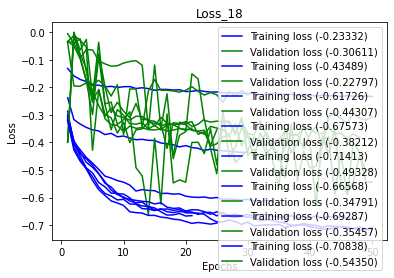

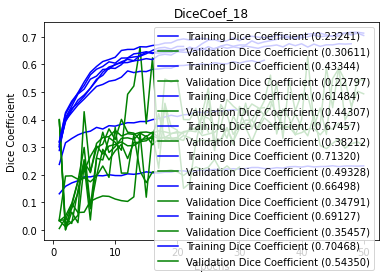

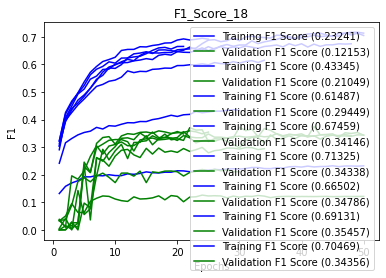

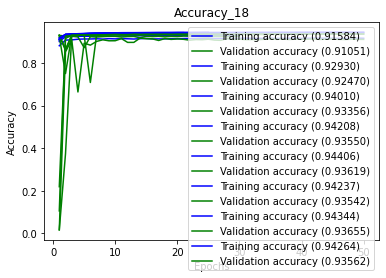

In [5]:
# Prepare EM iterator index.
EM_iterator = 0

print("Target Steps:", EM_target)
print(rebuild_model)

import random

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < EM_target:   
    
    # ---------------------------
    # 0. Initialization
    # ---------------------------
    section_tstamp = time.time()
    section_name = 'EM_Step {:02}'.format(EM_iterator)

    # Create folder for em step
    emfolder = os.path.join(test.dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\n\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    anno_stamp = time.time()
    
    # ---------------------------
    # 1. Creating New Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model (Skip first step since it was pre-generated)
    pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
    p_output = emt.Get_Pmap(train_raster, WinShape, unet_model, pmap_fp)
    
    print("\nGenerated Probability Output Map from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    # 1.2 Weight Candidate Frames
    newSegments = []
    for frame in candidateFrames:
        
        # Get Candidate Weights
        weightedFrame = emt.WeightCandidates(p_output, frame)
        
        # Select Likely or Top Candidate 
        if random.uniform(0,1) < random_candidate_chance:
            # Use 'likely' candidate (ENSURE Select_Candidate() FUNCTION IS UPDATED (lib/EMTools.py))
            newSegments.append(emt.Select_Candidate(weightedFrame, 'weight', weight_limit, default_random=default_random))
        else:
            # Use top candidate
            newSegments.append(emt.Top_Candidate(weightedFrame, 'weight', default_random=default_random))
        
        
    # 1.3 Convert List of segments to GeoDataFrame
    newSegmentFrame = gpd.GeoDataFrame(geometry=newSegments, crs=candidateFrames[0].crs)
    newSegmentFrame.to_file(os.path.join(emfolder, 'segments_{:02}.shp'.format(EM_iterator)))

    # 1.4 Connect top segments:
    newAnnotation = emt.Connect_Lines(newSegmentFrame, maxRepairDist)
    newAnnotation.to_file(os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator)))

    # 1.5 Save mean precision of this annotation.
    annoPrecision = emt.GDF_Precision(gt_labels, newAnnotation, precisionBuffer)

    
    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    anno_time = time.time() - anno_stamp
    
    # ---------------------------
    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    buff_anno = st.GDF_Buffer(newAnnotation, labelBuffer, flatten=True)
    anno_raster = st.GDF_Rasterize(buff_anno, train_raster)
    
    # 2.2 Read Y_train, Y_val
    Y_train = gt.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = gt.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = gt.AugmentImages(Y_train, h_flip=train_h_flip, v_flip=train_v_flip, rotate=train_rotate)
    Y_val = gt.AugmentImages(Y_val, h_flip=val_h_flip, v_flip=val_v_flip, rotate=val_rotate)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # ---------------------------
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    callbacks = SetCallbacks(emfolder + '/model_{:02}.h5'.format(EM_iterator))
    
    # 3.2 Determine Learning Rate from schedule
    #EM_learningRate = Step_LR_Schedule(learningRate, EM_iterator, EM_target, lr_const)
    EM_learningRate = learningRate #(EM_iterator%2 + 1)*learningRate/2
    if EM_iterator > 5:
        EM_learningRate = learningRateReduced
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learningRate, EM_iterator))
        
    training_stamp = time.time()
    with mirror_strategy.scope():
        unet_model = UNET_7_224()
        unet_model.compile(optimizer=Adam(lr=EM_learningRate), loss=dice_coef_loss, metrics=metrics)
        TrainData = unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=useShuffle, batch_size=batchSize, epochs=epochs, callbacks=callbacks)
    training_time = time.time() - training_stamp
    
    training_metrics = {
        'f1': Get_Metric_Data(TrainData, 'f1_score'),
        'dice_coef': Get_Metric_Data(TrainData, 'dice_coef'),
        'loss': Get_Metric_Data(TrainData, 'loss')
    }

    train_metrics_fp = os.path.join(emfolder, 'train_curve_{:02}.csv'.format(EM_iterator))
    with open(train_metrics_fp, 'a+', newline='\n') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter= ',')
        for key, data in training_metrics.items():
            csvwriter.writerow(['Training {}'.format(key)])
            csvwriter.writerow(data)
            
    validation_metrics = {
        'f1': Get_Metric_Data(TrainData, 'val_f1_score'),
        'dice_coef': Get_Metric_Data(TrainData, 'val_dice_coef'),
        'loss': Get_Metric_Data(TrainData, 'val_loss')
    }   
    val_metrics_fp = os.path.join(emfolder, 'val_curve_{:02}.csv'.format(EM_iterator))
    with open(val_metrics_fp, 'a+', newline='\n') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter= ',')
        for key, data in validation_metrics.items():
            csvwriter.writerow(['Validation {}'.format(key)])
            csvwriter.writerow(data)
    
    SaveHistory(TrainData, os.path.join(emfolder, 'trainingResults_{:02}'.format(EM_iterator)), test.end) # Save Plots
    
    print("\nCompleted UNet Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # ---------------------------
    # 4. Evaluate Model
    # ---------------------------

    
    # Training Results
    train_results = emt.Evaluate(X_train, Y_train, unet_model)
    # Validation Results
    val_results = emt.Evaluate(X_val, Y_val, unet_model)
    # Testing Results
    test_results = emt.Evaluate(X_test, Y_test, unet_model)

    
    
    # print
    print("\nCompleted Unet Evaluation. (Step {:02})".format(EM_iterator))
    print("\nTraining Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(train_results[0]))
    print("- {}".format(train_results[1]))
    print("\nValidation Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(val_results[0]))
    print("- {}".format(val_results[1]))   
    print("\nTesting Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(test_results[0]))
    print("- {}".format(test_results[1]))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    y_pred=np.copy(unet_model.predict(X_test))
    y_pred = np.round(y_pred)
    y_true=np.copy(Y_test)
    y_pred.shape = y_pred.shape[0]* y_pred.shape[1]*y_pred.shape[2]* y_pred.shape[3]
    y_true.shape = y_true.shape[0]* y_true.shape[1]*y_true.shape[2]* y_true.shape[3]

    c_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("confusion_unet", c_matrix)
    report_unet = classification_report(y_true, y_pred)
    print("report_unet", report_unet)
    
    # ---------------------------
    # 5. Save Step Data
    # ---------------------------
    
    # Save to dict for seperate CSV
    dataMatrix['precision'].append(annoPrecision*100)
    dataMatrix['trainDice'].append(train_results[0]) 
    dataMatrix['trainF1Score'].append(train_results[1]) 
    dataMatrix['valDice'].append(val_results[0]) 
    dataMatrix['valF1Score'].append(val_results[1]) 
    dataMatrix['testDice'].append(test_results[0]) 
    dataMatrix['testF1Score'].append(test_results[1]) 
    
    
    # Save EM Step Data 
    test.Results("EM Data {:02}".format(EM_iterator), {
            
        'Time Elapsed: Re-training': training_time,
        'Time Elapsed: New Annotation': anno_time,
            
        'Precision': '{:.2f}%'.format(annoPrecision*100),
        'SourceDelta': '{:.2f}%'.format((annoPrecision-sourcePrecision)*100),
        'StepDelta': '{:.2f}%'.format((annoPrecision-prevPrecision)*100),
        
        'UNet: LR': str(EM_learningRate),
        'UNet: Epochs': str(len(TrainData.history['dice_coef'])),
        
        'UNet: Training Results': train_results,
        'UNet: Validation Results': val_results,
        'UNet: Testing Results': test_results,
        'UNet: Confusion Matrix': c_matrix,
        'UNet: Report': report_unet
    })
    # Save as section
    section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
    test.Section(section_name, section_data)
    
    # Print step data
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print('- Precision: {:.2f}%'.format(annoPrecision*100))
    print('- SourceDelta: {:.2f}%'.format((annoPrecision-sourcePrecision)*100))
    print('- StepDelta: {:.2f}%'.format((annoPrecision-prevPrecision)*100))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prevPrecision = annoPrecision
 

### Save Test Data 

In [6]:
""" Save EM step data to csv
with open(os.path.join(test.dir, 'EM_Data.csv'), 'a+', newline='\n') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter= ',')
    csvwriter.writerow([test.name, 'Line Precisions (delta)', 'Train Dice Coef (delta)', 'Train F1 Score (delta)', 'Val Dice Coef (delta)', 'Val F1 Score (delta)', 'Test Dice Coef (delta)', 'Test F1 Score (delta)'])
    for i in range(len(dataMatrix['precision'])):
        row = ['step {:02}'.format(i)]
        for key, item in dataMatrix.items():
            row.append('{} ({})'.format(item[i], item[i]-item[0]))
        csvwriter.writerow(row)
"""

# Index test in master csv
test.index()

# Write test Info to Markdown
test.markdown()

# Print Completion
print("Data successfully saved to markdown file, indexed on csv.") 
print(dt.now().strftime('%a at %I:%M:%S%p'))


Data successfully saved to markdown file, indexed on csv.
Wed at 12:50:55AM
